In [15]:
%load_ext autoreload
%autoreload

import cv2
import matplotlib.pyplot as plt
import imageio
import numpy as np
from huggingface_hub import from_pretrained_keras
from transformers import pipeline
from PIL import Image, ImageDraw, ImageFont

import sys
sys.path.append("..")
from utils.helpers import extract_and_deskew_textlines, resize_image, return_scaled_image, do_prediction, write_dict_to_json, load_json_to_dict, perform_ocr_on_textlines, adjust_font_size, create_text_overlay_image, binarize_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# GENERAL ARGS - MODIFY!
img_path = '../test_data/schindler_image.jpg'
binarize_mode = 'fast' # 'detailed', 'fast', 'no'

### Inspect input image

C:\Users\phili\AppData\Local\Temp\ipykernel_17344\2760043657.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)


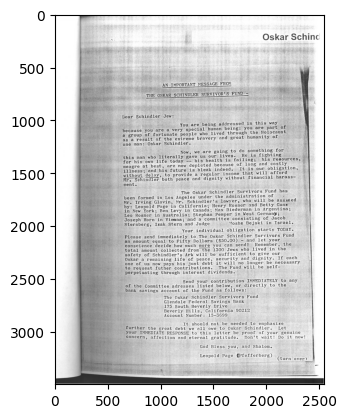

In [4]:
img = imageio.imread(img_path)
plt.imshow(img)

### Binarize image

In [10]:
binarized = binarize_image(img, 'detailed')
plt.imshow(binarized)

Fetching 6 files: 100%|██████████| 6/6 [00:00<?, ?it/s]


c:\Users\phili\anaconda3\envs\ocrd\lib\site-packages\keras\src\layers\core\lambda_layer.py:327: UserWarning: keras.layers.core is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


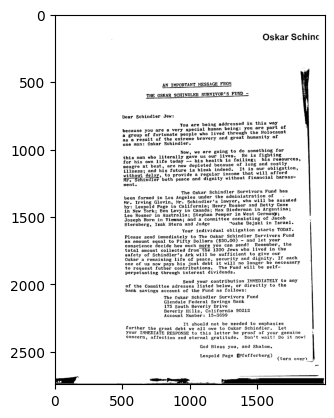

### Predict textlines segments

Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 5765.37it/s]
c:\Users\phili\anaconda3\envs\ocrd\lib\site-packages\keras\src\layers\core\lambda_layer.py:327: UserWarning: keras.layers.core is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


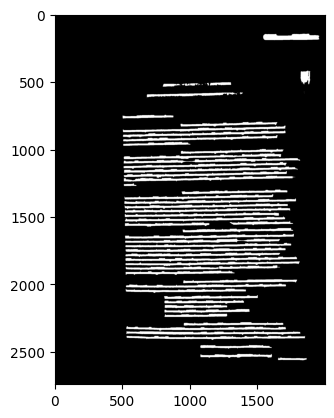

In [16]:
model_name = "SBB/eynollah-textline"
model = from_pretrained_keras(model_name)

textline_segments = do_prediction(model, binarized)
plt.imshow(textline_segments*255)

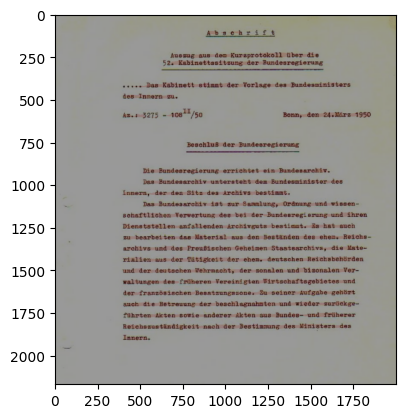

In [38]:
#plt.imshow(visualize_model_output(pred, img, model_name))

In [18]:
imageio.imwrite('../test_data/schindler_textlineSegments.png', textline_segments*255)
#textlines = imageio.imread('../test_data/schindler_textlines.png')

### Extract text lines from image and de-skew them (ToDo: make filtering values a function param!)

In [20]:
img_resized = return_scaled_image(img, 1, img.shape[1]) # textline_segments where predicted on rescaled image
textline_images = extract_and_deskew_textlines(img_resized, textline_segments[...,0])
len(textline_images['array'])

48

### Perform OCR

In [21]:
textline_preds = perform_ocr_on_textlines(textline_images)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
c:\Users\phili\anaconda3\envs\ocrd\lib\site-packages\transformers\generation\utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Processing image no. 1 of 48
Processing image no. 11 of 48
Processing image no. 21 of 48
Processing image no. 31 of 48


In [ ]:
write_dict_to_json(textline_preds, '../test_data/schindler_predsDetailed.json')
textline_preds = load_json_to_dict('../test_data/schindler_predsDetailed.json')

### Print textlines on generated image

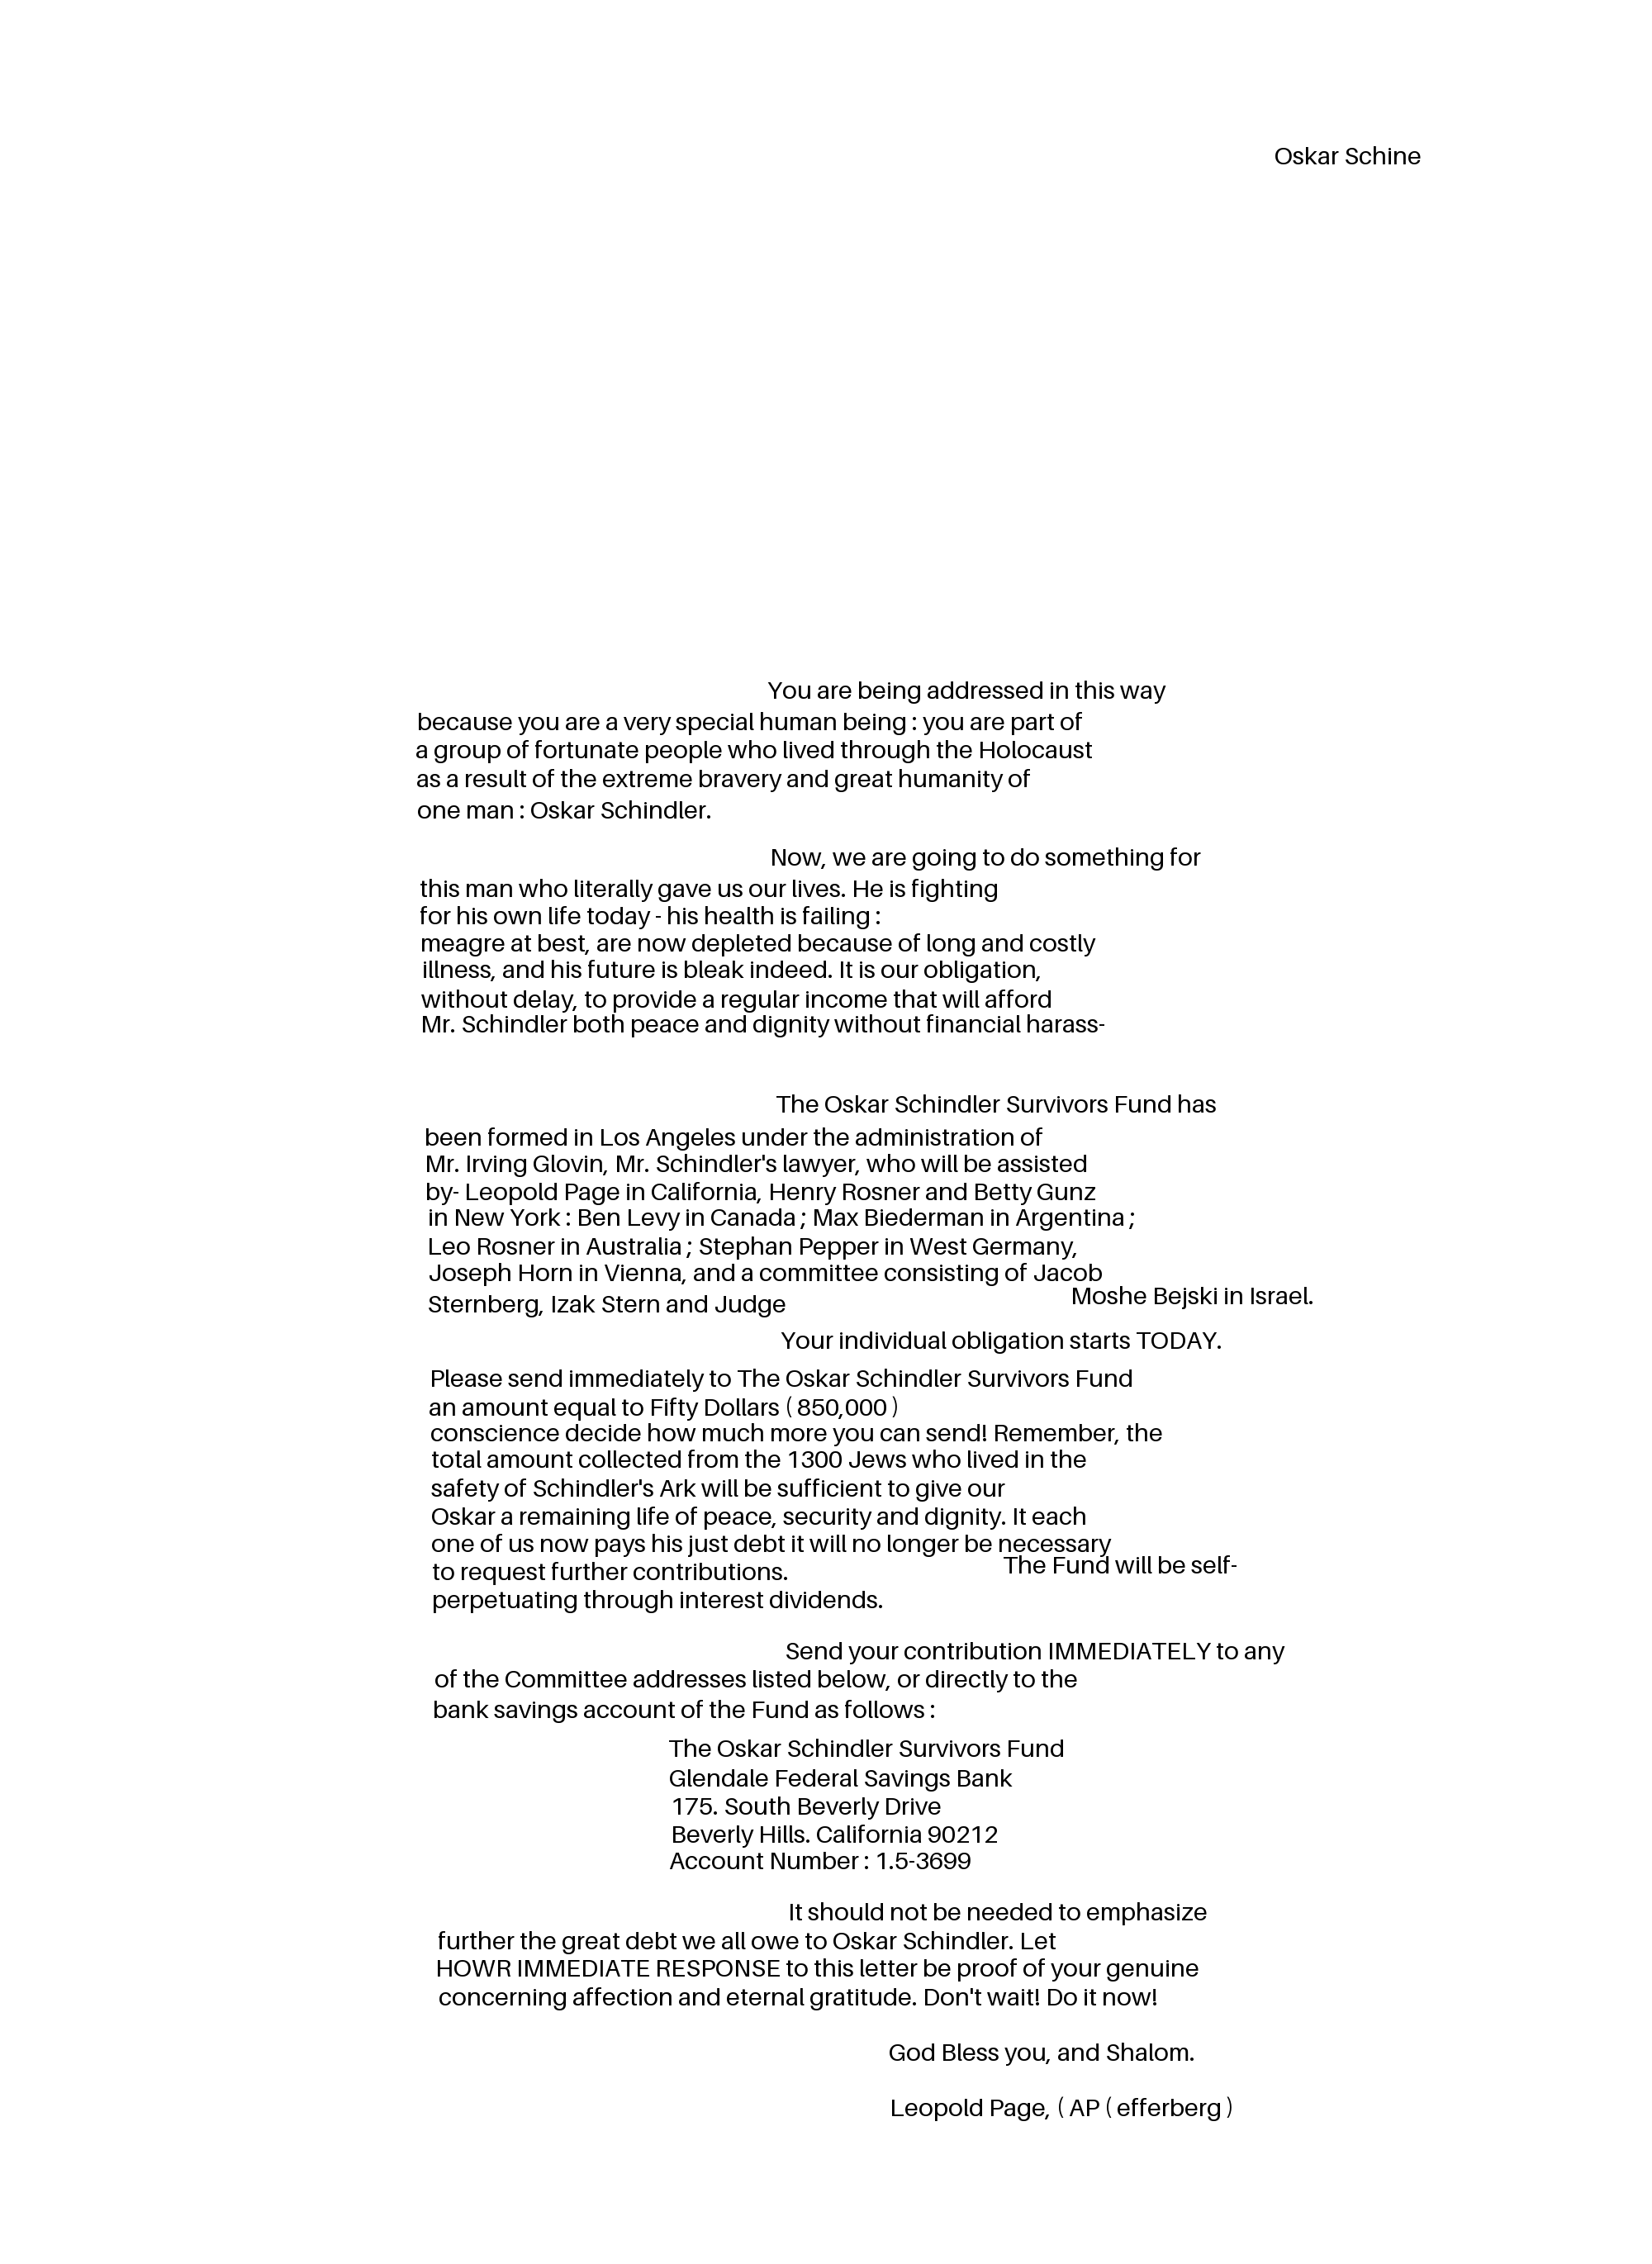

In [ ]:
img_gen = create_text_overlay_image(textline_images, textline_preds, (img_resized.shape[0], img_resized.shape[1]), font_size=30)
img_gen

In [33]:
cropped_img = img[1000:1224,1000:1448]
cropped_img = np.expand_dims(cropped_img, 0)

In [29]:
cropped_img = img[:448,:672]
cropped_img = np.expand_dims(cropped_img, 0)

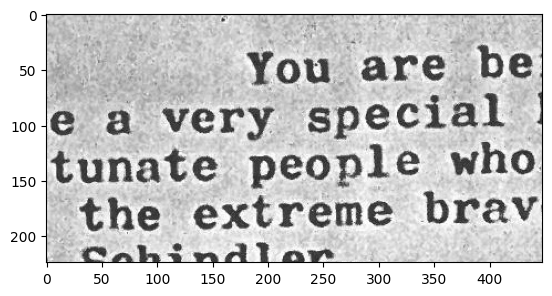

In [34]:
plt.imshow(cropped_img[0])

In [35]:
pred = model.predict(cropped_img/255)

1/1 [==============================] - 0s 353ms/step


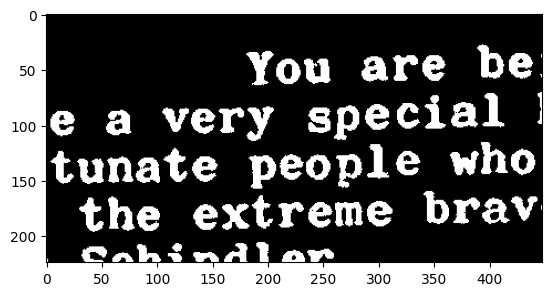

In [37]:
seg = np.argmax(pred, axis=3)[0]
seg_color = np.repeat(seg[:, :, np.newaxis], 3, axis=2)
plt.imshow(seg_color*255)

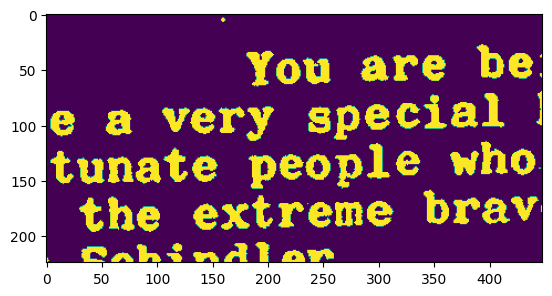

In [36]:
plt.imshow(pred[0,...,1]>.1)

In [41]:
pred = do_line_segmentation(model_name, img)

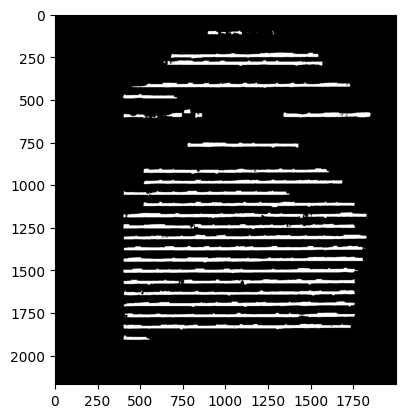

In [36]:
plt.imshow(pred*255)